In [1]:
from glob import glob
import os
from PIL import Image
from pdf2image import convert_from_path
import numpy as np
import pandas
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import editdistance as edis
from camelot import utils
from transformers import DetrImageProcessor
from transformers import TableTransformerForObjectDetection
from transformers import AutoFeatureExtractor, AutoModelForObjectDetection
import time
import PyPDF2

In [4]:
#layout, dim = utils.get_page_layout(path_to_pdf)
#dim_width,dim_height = int(dim[0]),int(dim[1])


In [5]:
#threshold for dertermining a table (based on its certainty)
threshold = 0.90

In [6]:
# Get the first page of the PDF
# Get the width of the page
# Get the height of the page


In [7]:
#convert pdf to list of PIL image
image_pages = []
pages = convert_from_path(path_to_pdf)
for i in range(len(pages)):
    image_pages.append(pages[i].resize((dim_width,dim_height)))

In [9]:

image_pages[0].size

(595, 841)

In [11]:
#preparing the image feature extractor
feature_extractor = DetrImageProcessor.from_pretrained("")

list_of_encoding = []
for page in image_pages:
    encoding = feature_extractor(page, return_tensors="pt")
    list_of_encoding.append(encoding)
encoding.keys()
     

C:\Users\tobia\miniconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [12]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 800, 566])


In [13]:
#get the model from huggingface. Might need to make a token from huggingface to use it
model = AutoModelForObjectDetection.from_pretrained("")    


In [14]:
outputs = []
for encode in list_of_encoding:
    with torch.no_grad():
        output = model(**encode)
        outputs.append(output)

In [15]:

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
def save_results_plot_results(pil_img, scores, labels, boxes, name):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    #plt.savefig('foo.jpg',dpi=300)
    #plt.savefig("data/detr/"+ str(name) + ".png")
    plt.show()
def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
     


In [16]:
# rescale bounding boxes
results = []
width, height = image_pages[0].size
for output in outputs:
    result = feature_extractor.post_process_object_detection(output, threshold=threshold, target_sizes=[(height,width)])[0]
    results.append(result)

In [17]:
[image_pages[0].size]

[(595, 841)]

In [18]:
results[0]['boxes']

tensor([], size=(0, 4))

In [19]:
#plot_results(image_pages[0], results[0]['scores'], results[0]['labels'], results[0]['boxes'])

In [20]:
#for i in range(0,len(image_pages)):
    #plot_results(image_pages[i], results[i]['scores'], results[i]['labels'], results[i]['boxes'])

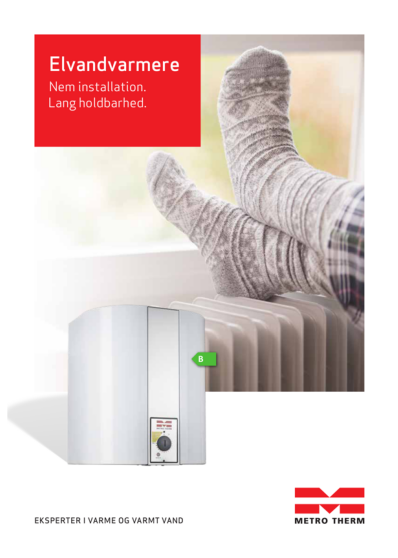

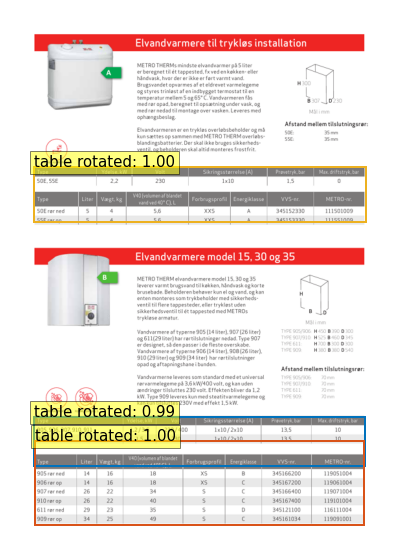

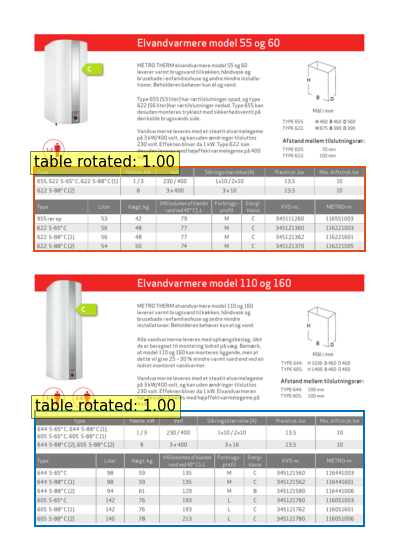

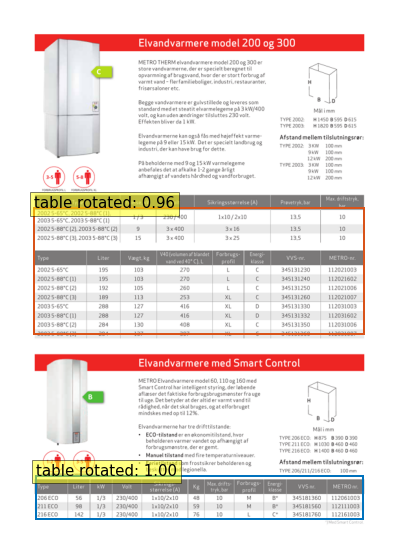

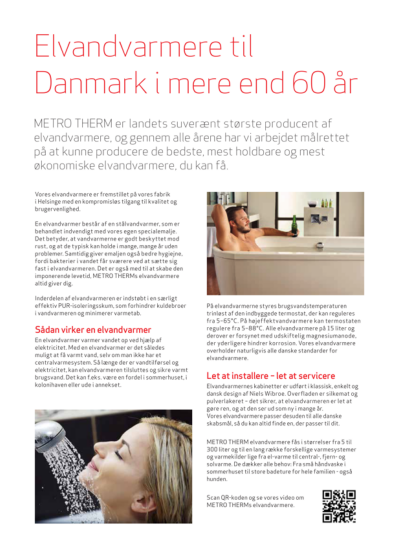

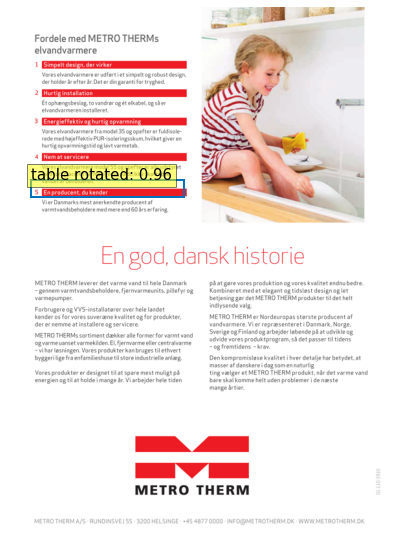

In [21]:
TESTTT = 0
for i in range(0,len(image_pages)):
    TESTTT += len(results[i]['labels'])
    plot_results(image_pages[i], results[i]['scores'], results[i]['labels'], results[i]['boxes'])

In [22]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        #text = f'{id2label[cl.item()+1]}: {p[cl]:0.2f}'
        #text = f'{id2label[cl.item()+1]}: {round(p[cl].item(),2)}'
        
    plt.axis('off')
    plt.show()

In [23]:
#Iterate through outputs and keep boxes with probability over threshold
probs = []
bool_probs = []
all_probs = []

for output in outputs:
    prob = output.logits.softmax(-1)[0, :, :-1]
    bool_probs.append(prob.max(-1).values > threshold)
    anybox = False
    all_probs.append(prob)
    temp_value = []
    for i in prob.max(-1).values:
        if i > threshold:
            anybox = True
            temp_value.append(i)
    if anybox:        
        probs.append(temp_value)

In [24]:
#Get bounding boxes from probabilities over threshold and rescale to image size
all_boxes = []
i = 0
page = 1
pwt = []
for output in outputs:
    boxes = rescale_bboxes(output.pred_boxes[0, bool_probs[i]].cpu(),image_pages[i].size)
    is_empty = tf.equal(tf.size(boxes),0)
    if not is_empty:
        all_boxes.append(boxes)
        pwt.append(str(page))
    i += 1
    page += 1

In [25]:
bool_probs

[tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False]),
 tensor([ True, False, False, False, False,  True, False, False, False, False,
         False, False, False,  True, False]),
 tensor([False, False, False, False, False,  True, False, False, False, False,
         False, False, False,  True, False]),
 tensor([False, False, False, False, False,  True, False, False, False, False,
         False, False, False,  True, False]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False]),
 tensor([False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False])]

In [26]:
#this one is hardcoded for visuals. might not work for you
#plot_results(image_pages[int(pwt[0])-1], all_probs[0][bool_probs[0]],all_boxes[0])

[[[40.64189147949219, 633.9298706054688, 553.2349853515625, 708.965576171875],
  [42.57793045043945, 670.2735595703125, 551.821044921875, 800.85107421875],
  [40.883140563964844,
   247.17025756835938,
   555.0200805664062,
   331.39764404296875]],
 [[43.15153884887695, 624.4979248046875, 551.8916625976562, 801.8579711914062],
  [40.304073333740234, 246.28561401367188, 553.02001953125, 376.041015625]],
 [[43.69234085083008, 725.3208618164062, 549.9129028320312, 791.6713256835938],
  [41.44898223876953,
   310.8975524902344,
   551.8204345703125,
   505.57122802734375]],
 [[36.935157775878906,
   267.1434020996094,
   273.6933898925781,
   293.4315490722656]]]

In [30]:
#table_areas_string = []
#for i in range(len(list_of_cordi)):
#    table_areas_string.append(str(table_areas[i])[1:-1])

In [31]:
pages_table_areas[0][0]

'40.64189147949219, 207.07012939453125, 553.2349853515625, 132.034423828125'

In [35]:
#end = time.time()
#totaltime = end - start
#print(name_of_pdf)
#print("len is: "+str(len(image_pages)))
#print("Dims are: " + str(dim_width)+" " + str(dim_height))
#print("Number of tables: " + str(TESTTT))
#print("Total time: " +str(totaltime))
#STTTTOOP

###### 